In [3]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L
import numpy as np

In [6]:
from src.datasets.utils import load_autoencoder_data
from src.config import DATA_DIR

train_loader, val_loader, test_loader = load_autoencoder_data(
    data_dir=f'{DATA_DIR}/processed/3/3.npz',
    val_split = 0.1,
    test_split = 0.1,
    shuffle = True,
    seed = 42,
    batch_size = 256,
    slice_time_steps = (10, 399)
)

In [18]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim, input_shape, n_encoder_layers=4, channels_base=16, dropout=0.5):
        super(ConvAutoEncoder, self).__init__()
        self.__version__ = "v1.0.0"
        self.input_shape = input_shape  # (height, width)
        self.n_encoder_layers = n_encoder_layers
        self.channels_base = channels_base

        # Build encoder and track spatial dimensions
        self.encoder, self.encoder_shapes = self._build_encoder(dropout)

        # Calculate flattened size after encoder
        last_channels, last_height, last_width = self.encoder_shapes[-1]
        self.flattened_size = last_channels * last_height * last_width

        # Latent space layers
        self.fc_enc = nn.Sequential(
            nn.Linear(self.flattened_size, latent_dim),
            nn.LeakyReLU(True),
        )
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.LeakyReLU(True),
        )

        # Build decoder
        self.decoder = self._build_decoder(dropout)

    def _build_encoder(self, dropout):
        layers = []
        current_channels = 1  # Input channels
        current_height, current_width = self.input_shape
        shapes = [(current_channels, current_height, current_width)]

        for layer_idx in range(self.n_encoder_layers):
            out_channels = self.channels_base * (2 ** layer_idx)

            conv_block = [
                nn.Conv2d(current_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(True)
            ]

            # Add dropout to all layers except last
            if layer_idx != self.n_encoder_layers - 1:
                conv_block.append(nn.Dropout2d(dropout))

            layers.extend(conv_block)

            # Update spatial dimensions
            current_height = (current_height + 2*1 - 3) // 2 + 1
            current_width = (current_width + 2*1 - 3) // 2 + 1
            current_channels = out_channels
            shapes.append((current_channels, current_height, current_width))

        return nn.Sequential(*layers), shapes

    def _build_decoder(self, dropout):
        layers = []
        decoder_shapes = self.encoder_shapes[::-1][:-1]  # Reverse and exclude input shape

        current_channels, current_h, current_w = decoder_shapes[0]

        for layer_idx in range(self.n_encoder_layers):
            # Determine target shape
            if layer_idx < self.n_encoder_layers - 1:
                next_channels, target_h, target_w = decoder_shapes[layer_idx+1]
            else:
                next_channels = 1
                target_h, target_w = self.input_shape

            # Calculate output padding
            output_padding_h = target_h - ((current_h - 1)*2 - 2*1 + 3)
            output_padding_w = target_w - ((current_w - 1)*2 - 2*1 + 3)
            output_padding = output_padding_h  # Assuming square images

            # Create transpose conv layer
            conv_t = nn.ConvTranspose2d(
                current_channels, next_channels,
                kernel_size=3, stride=2, padding=1,
                output_padding=output_padding
            )
            layers.append(conv_t)

            # Add activations and dropout
            if layer_idx != self.n_encoder_layers - 1:
                layers.append(nn.LeakyReLU(True))
                layers.append(nn.Dropout2d(dropout))
            else:
                layers.append(nn.Sigmoid())

            current_channels = next_channels
            current_h, current_w = target_h, target_w

        return nn.Sequential(*layers)

    def forward(self, x):
        batch_size, h, w = x.size()
        x = x.view(batch_size, 1, h, w)

        # Encode
        x = self.encoder(x)
        x = x.view(batch_size, -1)
        x = self.fc_enc(x)

        # Decode
        x = self.fc_dec(x)
        x = x.view(batch_size, *self.encoder_shapes[-1])
        x = self.decoder(x)

        # Reshape back to original format
        x = x.view(batch_size, *self.input_shape)
        return x

    def encode(self, x):
        batch_size, h, w = x.size()
        x = x.view(batch_size, 1, h, w)
        x = self.encoder(x)
        x = x.view(batch_size, -1)
        return self.fc_enc(x).view(batch_size, -1)

    def decode(self, z):
        batch_size, seq_len, latent_dim = z.size()
        z = z.view(batch_size * seq_len, latent_dim)
        z = self.fc_dec(z)
        z = z.view(batch_size * seq_len, *self.encoder_shapes[-1])
        return self.decoder(z).view(batch_size, seq_len, *self.input_shape)

In [19]:
import lightning.pytorch as pl


class LitConvAutoEncoder(pl.LightningModule):
    def __init__(self, latent_dim, n_encoder_layers, channels_base, lr=1e-3, weight_decay=1e-5, dropout=0.5):
        super(LitConvAutoEncoder, self).__init__()
        self.save_hyperparameters()
        self.model = ConvAutoEncoder(
            input_shape=(200, 200),
            latent_dim=latent_dim,
            n_encoder_layers=n_encoder_layers,
            channels_base=channels_base,
            dropout=dropout
        )
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss_fn(output, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss_fn(output, y)
        self.log("val_loss", loss, prog_bar=True)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [lr_sched]
        #return optimizer

In [40]:
from src.config import MODELS_DIR

# load from checkpoint and load hyperparameters
conv_ae = LitConvAutoEncoder.load_from_checkpoint(
    f'{MODELS_DIR}/dataset_3/ConvAutoEncoder/v1.0.1/training_runs/version_1/checkpoints/epoch=100-step=6161.ckpt',
)

In [41]:
# evaluate loss on training
trainer = L.Trainer()
trainer.validate(
    model=conv_ae,
    dataloaders=[val_loader]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.002104448154568672    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.002104448154568672}]

## We now want to visualize the latent space of the ConvAutoEncoder, trying to understand if the model is able to capture the underlying structure of the data.

In [42]:
conv_ae = conv_ae.eval()

In [64]:
for X, y in val_loader:
    z = conv_ae.model.encode(X)
    break

In [45]:
z = z.cpu().detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

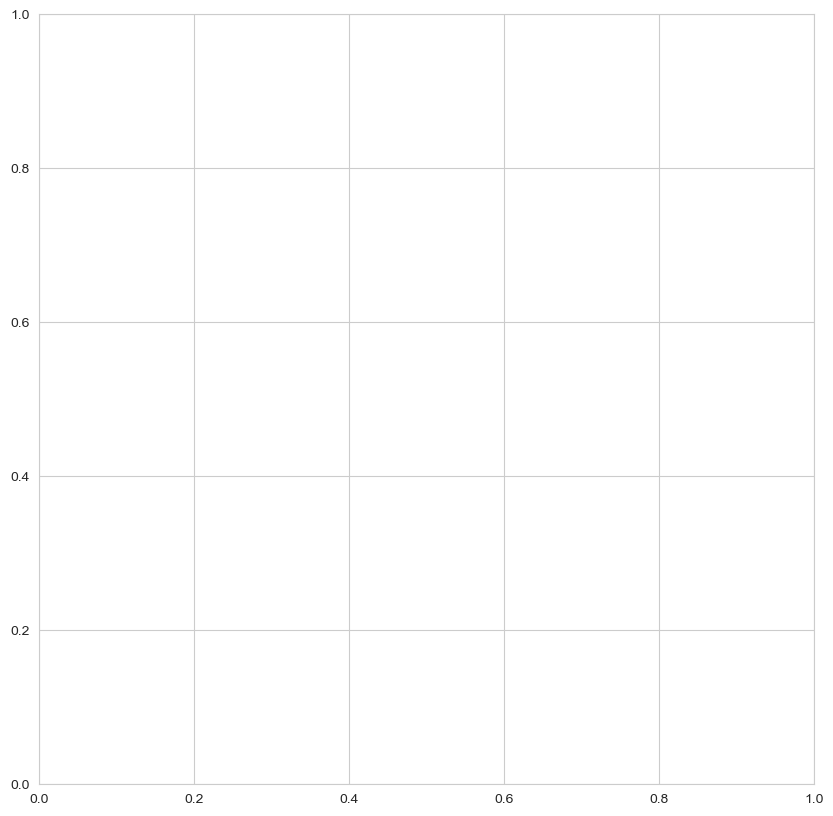

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(z)

In [66]:
# Look at the reconstruction
X_hat = conv_ae(X)

X = X.cpu().detach().numpy()
X_hat = X_hat.cpu().detach().numpy()

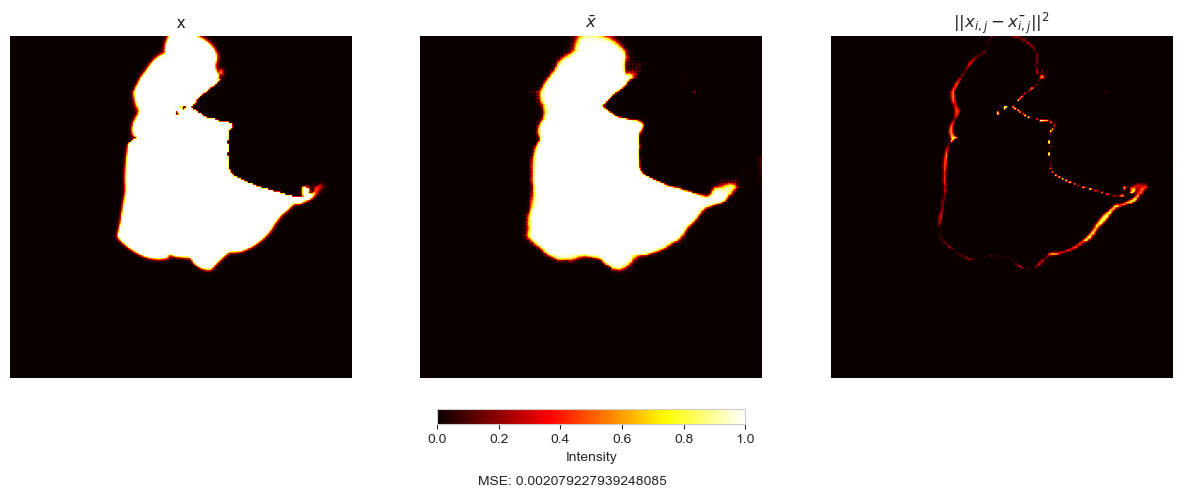

In [81]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Set the same colorbar for both images
id = 31
im0 = axs[0].imshow(X[id], cmap='hot', vmax=1, vmin=0)
im1 = axs[1].imshow(X_hat[id], cmap='hot', vmax=1, vmin=0)
# im2 = axs[2].imshow(np.abs(X_hat[id] - X[id]), cmap='hot', vmax=1, vmin=0)
# norm sqared error
im2 = axs[2].imshow((X_hat[id] - X[id])**2, cmap='hot', vmax=1, vmin=0)

axs[0].set_title('x')
axs[1].set_title(r'$\bar{x}$')
axs[2].set_title(r'$||x_{i, j} - \bar{x_{i, j}}||^2$')

# put the mse value on the plot below the colorbar
mse = np.mean((X_hat - X)**2)
fig.text(0.5, 0.05, f'MSE: {mse}', ha='center')

# Remove axis
for ax in axs:
    ax.axis('off')

# Add a colorbar
cbar = fig.colorbar(im0, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
cbar.set_label('Intensity')

plt.show()

In [82]:
# save the plot as a jpeg file
fig.savefig('reconstruction.jpg', bbox_inches='tight')

In [48]:
from src.modeling.models import ConvAutoEncoder as OldConvAutoEncoder

old_conv_ae = OldConvAutoEncoder(shape=(200, 200), latent_dim=10)

old_conv_ae.load_state_dict(torch.load(f'{MODELS_DIR}/dataset_3/ConvAutoEncoder/v1.0.0/training_runs/1/weights.pth', weights_only=True))

<All keys matched successfully>

In [55]:
old_conv_ae.eval()

for X, y in val_loader:
    z = old_conv_ae.encode(X)
    break

In [56]:
# Look at the reconstruction
X_hat = old_conv_ae(X)

X = X.cpu().detach().numpy()
X_hat = X_hat.cpu().detach().numpy()

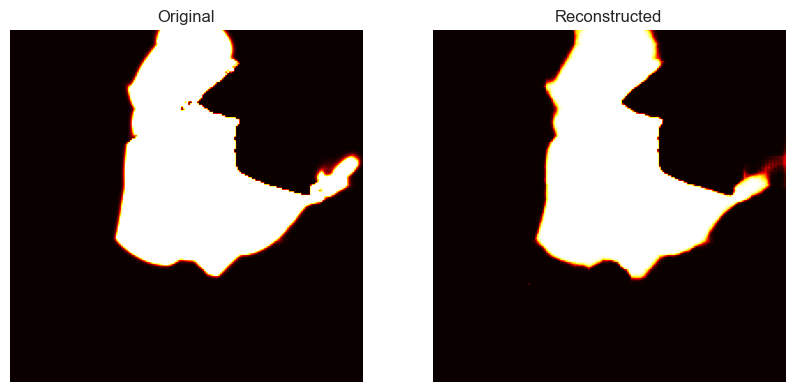

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

id = 34
axs[0].imshow(X[id], cmap='hot')
axs[1].imshow(X_hat[id], cmap='hot')

axs[0].set_title('Original')
axs[1].set_title('Reconstructed')

# remove axis
for ax in axs:
    ax.axis('off')

plt.show()

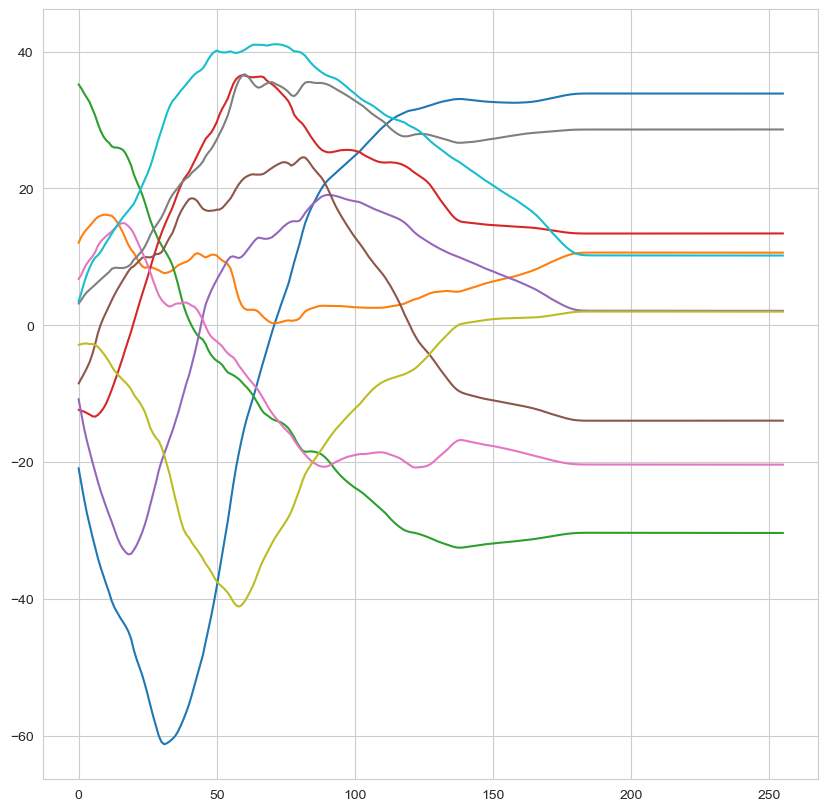

In [58]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(z.cpu().detach().numpy())